In [28]:
## importing libraries ##

# Essentials
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  # Assuming the task is regression
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation

# Setting pandas print options (optional but useful for large dataframes)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## importing data ##

file_path = './datasets/chicago_training_data.xlsx'

# Reading training data into Python
modeling_data = './datasets/train.xlsx'
df_train = pd.read_excel(io=modeling_data, sheet_name='data', header=0, index_col='ID')

# Reading testing data into Python
testing_data = './datasets/test.xlsx'
df_test = pd.read_excel(io=testing_data, sheet_name='data', header=0, index_col='ID')

# Concatenating datasets together for missing value analysis and feature engineering
df_train['set'] = 'Not Kaggle'
df_test['set'] = 'Kaggle'

# Concatenating both datasets together for MV analysis and feature engineering
df_full = pd.concat(objs=[df_train, df_test], axis=0, ignore_index=False)

# Checking the concatenated data
print(df_full.head(n=5))

                           DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2) Holiday FunctioningDay  RENTALS         set
ID                                                                                                                                                                                                                          
mb_1039  2023-10-14 05:59:54.810000              52           81               0.4                2.9                    46.4           0.0           0.0                   0.00      No            Yes    519.0  Not Kaggle
mb_1330  2023-10-26 08:59:53.355000              51           53               2.2                NaN                    35.2           0.0           0.0                   1.01      No            Yes   1251.0  Not Kaggle
mb_551   2023-09-23 21:59:57.250000              56           49               2.5                3.4               

In [29]:
# Seleccionar solo columnas numéricas para el cálculo de la matriz de correlación
numeric_cols = df_train.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación solo para columnas numéricas
correlation_matrix = numeric_cols.corr()

# Mostrar la correlación con 'RENTALS'
correlations_with_rentals = correlation_matrix['RENTALS'].sort_values(ascending=False)
print("Correlaciones con RENTALS:\n", correlations_with_rentals)

Correlaciones con RENTALS:
 RENTALS                   1.000000
Temperature(F)            0.322811
SolarRadiation(MJ/m2)     0.207526
Wind speed (mph)          0.186261
DewPointTemperature(F)    0.030903
Visibility(miles)         0.004390
Snowfall(in)             -0.086884
Rainfall(in)             -0.145802
Humidity(%)              -0.395309
Name: RENTALS, dtype: float64


In [23]:
# checking available features
df_full.columns

Index(['DateHour', 'Temperature(F)', 'Humidity(%)', 'Wind speed (mph)', 'Visibility(miles)', 'DewPointTemperature(F)', 'Rainfall(in)', 'Snowfall(in)', 'SolarRadiation(MJ/m2)', 'Holiday', 'FunctioningDay', 'RENTALS', 'set'], dtype='object')

In [30]:
# 1. Manejo de valores faltantes
df_full['Visibility(miles)'] = df_full['Visibility(miles)'].fillna(df_full['Visibility(miles)'].median())

df_full['DateHour'] = pd.to_datetime(df_full['DateHour'], errors='coerce')

# 2. Codificación de variables categóricas
df_full['Holiday'] = df_full['Holiday'].map({'No': 0, 'Yes': 1})
df_full['FunctioningDay'] = df_full['FunctioningDay'].map({'No': 0, 'Yes': 1})

# 3. Ingeniería de características con `DateHour`
df_full['DateHour'] = pd.to_datetime(df_full['DateHour'])
df_full['Hour'] = df_full['DateHour'].dt.hour
df_full['DayOfWeek'] = df_full['DateHour'].dt.dayofweek  # Monday=0, Sunday=6
df_full['Month'] = df_full['DateHour'].dt.month





In [31]:
import numpy as np

# Asumiendo df_train es tu conjunto de datos de entrenamiento y estas columnas existen y son positivas.
# Si hay valores cero, considera sumar 1 para evitar el logaritmo de cero.
df_train['Wind speed (mph)'] = np.log(df_train['Wind speed (mph)'] + 1)
df_train['SolarRadiation(MJ/m2)'] = np.log(df_train['SolarRadiation(MJ/m2)'] + 1)
df_train['Humidity(%)_log'] = np.log(df_train['Humidity(%)'] + 1)

In [36]:
# Asegurarse de que 'DateHour' se ha convertido correctamente a datetime
df_train['DateHour'] = pd.to_datetime(df_train['DateHour'], errors='coerce')

# Extraer 'Hour' y 'DayOfWeek' de 'DateHour'
df_train['Hour'] = df_train['DateHour'].dt.hour
df_train['DayOfWeek'] = df_train['DateHour'].dt.dayofweek  # Añadiendo esta línea para extraer el día de la semana

# Ahora que 'DayOfWeek' ha sido extraído, crear la variable binaria para fin de semana
df_train['Weekend'] = df_train['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Crear variables binarias para momentos del día, asegurándose de que 'Hour' y 'DayOfWeek' existen
df_train['Morning'] = df_train['Hour'].apply(lambda x: 1 if 5 <= x < 12 else 0)
df_train['Afternoon'] = df_train['Hour'].apply(lambda x: 1 if 12 <= x < 17 else 0)
df_train['Evening'] = df_train['Hour'].apply(lambda x: 1 if 17 <= x < 21 else 0)
df_train['Night'] = df_train['Hour'].apply(lambda x: 1 if 21 <= x or x < 5 else 0)



In [33]:
# Interacciones
df_train['Temp*Wind'] = df_train['Temperature(F)'] * df_train['Wind speed (mph)']
df_train['Temp*Solar'] = df_train['Temperature(F)'] * df_train['SolarRadiation(MJ/m2)']


In [34]:
from sklearn.preprocessing import StandardScaler

# Seleccionar solo columnas numéricas para la estandarización
numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_train[numeric_cols]

# Asegúrate de excluir la variable objetivo 'RENTALS' si está en df_train
X = df_numeric.drop(['RENTALS'], axis=1)
y = df_train['RENTALS']

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar estandarización solo a las columnas numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Transformar de vuelta a DataFrame para conservar los nombres de las columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [38]:
# Eliminar valores infinitos si los hay
variables.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputar los valores NaNs con la mediana de cada columna
variables = variables.fillna(variables.median())

# Ahora calcular el VIF nuevamente
vif_data = pd.DataFrame()
vif_data["feature"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(len(variables.columns))]

print(vif_data)


                   feature         VIF
0           Temperature(F)  318.654394
1              Humidity(%)  153.690839
2         Wind speed (mph)  215.856682
3        Visibility(miles)    9.681891
4   DewPointTemperature(F)  134.348392
5             Rainfall(in)    1.181797
6             Snowfall(in)    1.147178
7    SolarRadiation(MJ/m2)   51.763483
8          Humidity(%)_log  457.743416
9                Temp*Wind  237.973032
10              Temp*Solar   56.279875
11                    Hour    7.887358
12                 Morning    2.350591
13               Afternoon    2.076052
14                 Evening    2.007600
15                   Night    2.465994
16               DayOfWeek   11.549753
17                 Weekend    3.703698


In [41]:
# Eliminar variables con VIF muy alto
variables = variables.drop(['Temperature(F)', 'Humidity(%)', 'Wind speed (mph)', 'DewPointTemperature(F)', 'Humidity(%)_log'], axis=1)


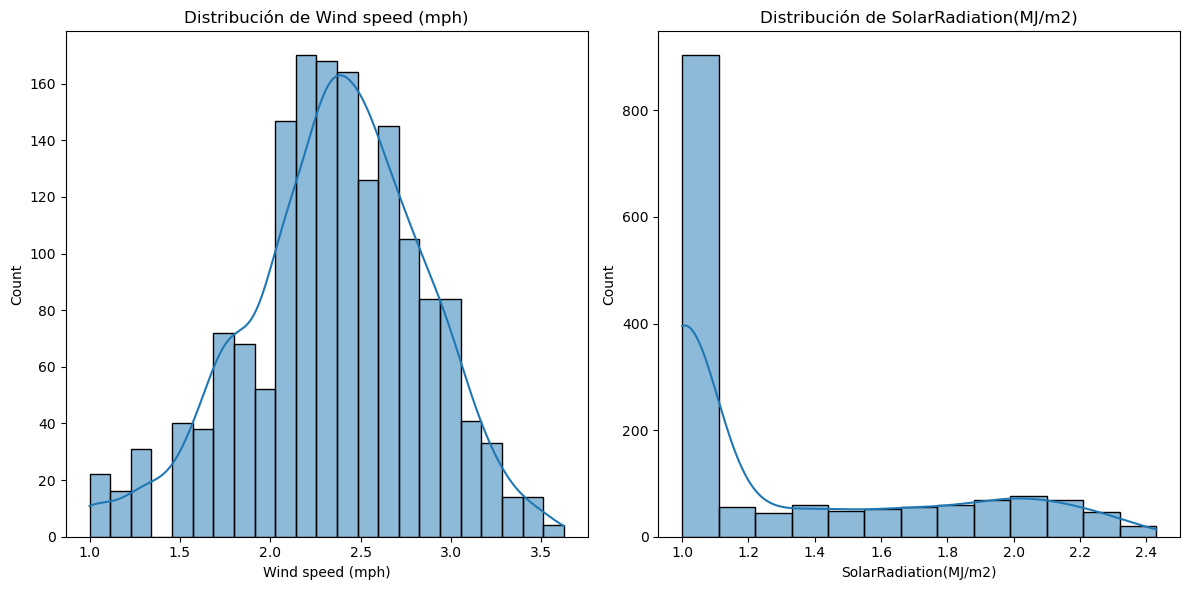

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la distribución de las variables
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['Wind speed (mph)'], kde=True)
plt.title('Distribución de Wind speed (mph)')

plt.subplot(1, 2, 2)
sns.histplot(df_train['SolarRadiation(MJ/m2)'], kde=True)
plt.title('Distribución de SolarRadiation(MJ/m2)')

plt.tight_layout()
plt.show()


In [53]:
import numpy as np

# Asegurar que todos los valores sean positivos
df['Wind speed (mph)'] += 1
df['SolarRadiation(MJ/m2)'] += 1

# Aplicar transformación logarítmica
df['Wind speed (mph)_log'] = np.log(df['Wind speed (mph)'])
df['SolarRadiation(MJ/m2)_log'] = np.log(df['SolarRadiation(MJ/m2)'])

# Crear la columna 'Weekend' basada en 'DayOfWeek'
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Eliminar valores infinitos y reemplazarlos por NaN para una imputación coherente
variables_actualizadas.replace([np.inf, -np.inf], np.nan, inplace=True)

# Opción 1: Imputar los valores NaNs con la mediana (o media) de cada columna
for column in variables_actualizadas.columns:
    variables_actualizadas[column].fillna(variables_actualizadas[column].median(), inplace=True)

# Opción 2: Eliminar filas que contienen NaNs (utilizar con precaución, dependiendo de tu conjunto de datos)
# variables_actualizadas.dropna(inplace=True)

# Verificar que no hay más valores infinitos o NaNs
assert not variables_actualizadas.isnull().values.any(), "Aún hay valores NaN en el DataFrame."
assert np.isfinite(variables_actualizadas).all().all(), "Aún hay valores infinitos en el DataFrame."

# Ahora, calcular el VIF nuevamente
vif_data_adjusted = pd.DataFrame()
vif_data_adjusted["feature"] = variables_actualizadas.columns
vif_data_adjusted["VIF"] = [variance_inflation_factor(variables_actualizadas.values, i) for i in range(len(variables_actualizadas.columns))]

print(vif_data_adjusted)




                      feature           VIF
0           Visibility(miles)      9.666517
1                Rainfall(in)      1.077616
2                Snowfall(in)      1.091878
3       SolarRadiation(MJ/m2)  18376.310674
4                   Temp*Wind     55.655744
5                  Temp*Solar     70.456886
6                        Hour      7.661627
7                     Morning      2.199365
8                   Afternoon      2.199875
9                     Evening      2.017920
10                      Night      2.518268
11                  DayOfWeek     11.490239
12                    Weekend      3.682799
13        Wind speed (mph)_bc   8604.925804
14        Wind speed (mph)_yj  21020.608594
15       Wind speed (mph)_log   1764.604020
16  SolarRadiation(MJ/m2)_log  10919.661455


In [51]:
# Asumiendo df_full es tu DataFrame completo que incluye tanto los datos de Kaggle como los de modelado

# Separar los datos para Kaggle
kaggle_data = df_full[df_full['set'] == 'Kaggle'].copy()

# Datos para la construcción del modelo
df = df_full[df_full['set'] == 'Not Kaggle'].copy()

# Eliminar el identificador 'set'
kaggle_data.drop(labels='set', axis=1, inplace=True)
df.drop(labels='set', axis=1, inplace=True)


In [55]:
from sklearn.model_selection import train_test_split

# Asumiendo 'y_variable' es el nombre de tu variable objetivo, por ejemplo, 'RENTALS'
y_variable = 'RENTALS'

# Escoge tus variables x (características), asegurándote de excluir cualquier variable no numérica o no deseada
x_features = ['Temperature(F)', 'Humidity(%)', 'Wind speed (mph)_log', 'SolarRadiation(MJ/m2)_log', 'Visibility(miles)', 'Rainfall(in)', 'Snowfall(in)', 'Holiday', 'FunctioningDay', 'Hour', 'DayOfWeek', 'Weekend']  # Ajusta esta lista según las variables que decidas mantener

# Preparar los datos manteniendo solo las columnas numéricas en x_features y eliminando filas con valores faltantes de manera coordinada en 'df'
df_clean = df.dropna(subset=x_features + [y_variable])

# Ahora, prepara y_data y x_data con el mismo número de observaciones
y_data = df_clean[y_variable]
x_data = df_clean[x_features].select_dtypes(include=[np.number])

# Split de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=702)

# Resultados del split de entrenamiento y prueba
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}

Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}

Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}

Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}

Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}
""")



Original Dataset Dimensions
---------------------------
Observations (Rows): 1638
Features  (Columns): 18

Training Data (X-side)
----------------------
Observations (Rows): 794
Features  (Columns): 12

Training Data (y-side)
----------------------
Feature Name:        RENTALS
Observations (Rows): 794

Testing Data (X-side)
---------------------
Observations (Rows): 265
Features  (Columns): 12

Testing Data (y-side)
---------------------
Feature Name:        RENTALS
Observations (Rows): 265



In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Nombrando el modelo
model_name_dt = 'Decision Tree Regressor'

# Tipo de modelo
model_dt = DecisionTreeRegressor(random_state=702)

# Ajustando el modelo a los datos de entrenamiento
model_dt.fit(x_train, y_train)

# Prediciendo sobre nuevos datos
model_pred_dt = model_dt.predict(x_test)

# Puntuaciones del modelo
model_train_score_dt = model_dt.score(x_train, y_train).round(4)
model_test_score_dt = model_dt.score(x_test, y_test).round(4)
model_gap_dt = abs(model_train_score_dt - model_test_score_dt).round(4)

# Resumen de los resultados del modelo
model_summary_dt = f"""
Model Name:     {model_name_dt}
Train_Score:    {model_train_score_dt}
Test_Score:     {model_test_score_dt}
Train-Test Gap: {model_gap_dt}
"""

print(model_summary_dt)



Model Name:     Decision Tree Regressor
Train_Score:    1.0
Test_Score:     0.6681
Train-Test Gap: 0.3319



In [57]:
from sklearn.neighbors import KNeighborsRegressor

# Nombrando el modelo
model_name_knn = 'K-Nearest Neighbors Regressor'

# Tipo de modelo
model_knn = KNeighborsRegressor()

# Ajustando el modelo a los datos de entrenamiento
model_knn.fit(x_train, y_train)

# Prediciendo sobre nuevos datos
model_pred_knn = model_knn.predict(x_test)

# Puntuaciones del modelo
model_train_score_knn = model_knn.score(x_train, y_train).round(4)
model_test_score_knn = model_knn.score(x_test, y_test).round(4)
model_gap_knn = abs(model_train_score_knn - model_test_score_knn).round(4)

# Resumen de los resultados del modelo
model_summary_knn = f"""
Model Name:     {model_name_knn}
Train_Score:    {model_train_score_knn}
Test_Score:     {model_test_score_knn}
Train-Test Gap: {model_gap_knn}
"""

print(model_summary_knn)



Model Name:     K-Nearest Neighbors Regressor
Train_Score:    0.5989
Test_Score:     0.3996
Train-Test Gap: 0.1993



In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo y los parámetros para la búsqueda de cuadrícula
model_dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Búsqueda de cuadrícula
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_search_dt.fit(x_train, y_train)

# Mejores parámetros y puntaje
print("Mejores parámetros (Árbol de Decisión):", grid_search_dt.best_params_)
print("Mejor puntaje (Árbol de Decisión):", grid_search_dt.best_score_)


Mejores parámetros (Árbol de Decisión): {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mejor puntaje (Árbol de Decisión): 0.7497144644441258


In [59]:
from sklearn.neighbors import KNeighborsRegressor

# Definir el modelo y los parámetros para la búsqueda de cuadrícula
model_knn = KNeighborsRegressor()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Búsqueda de cuadrícula
grid_search_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid_knn, cv=5, scoring='r2', n_jobs=-1)
grid_search_knn.fit(x_train, y_train)

# Mejores parámetros y puntaje
print("Mejores parámetros (KNN):", grid_search_knn.best_params_)
print("Mejor puntaje (KNN):", grid_search_knn.best_score_)


Mejores parámetros (KNN): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Mejor puntaje (KNN): 0.45975565466704305


In [66]:
import numpy as np
import pandas as pd

# Primero, asegúrate de que 'DateHour' en kaggle_data sea de tipo datetime
kaggle_data['DateHour'] = pd.to_datetime(kaggle_data['DateHour'], errors='coerce')

# Aplicar las mismas transformaciones logarítmicas y ajustes a 'Wind speed (mph)' y 'SolarRadiation(MJ/m2)'
kaggle_data['Wind speed (mph)'] += 1
kaggle_data['SolarRadiation(MJ/m2)'] += 1

kaggle_data['Wind speed (mph)_log'] = np.log(kaggle_data['Wind speed (mph)'])
kaggle_data['SolarRadiation(MJ/m2)_log'] = np.log(kaggle_data['SolarRadiation(MJ/m2)'])

# Extraer 'Hour' y 'DayOfWeek' de 'DateHour'
kaggle_data['Hour'] = kaggle_data['DateHour'].dt.hour
kaggle_data['DayOfWeek'] = kaggle_data['DateHour'].dt.dayofweek

# Crear la columna 'Weekend' y otras variables binarias para momentos del día
kaggle_data['Weekend'] = kaggle_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

kaggle_data['Morning'] = kaggle_data['Hour'].apply(lambda x: 1 if 5 <= x < 12 else 0)
kaggle_data['Afternoon'] = kaggle_data['Hour'].apply(lambda x: 1 if 12 <= x < 17 else 0)
kaggle_data['Evening'] = kaggle_data['Hour'].apply(lambda x: 1 if 17 <= x < 21 else 0)
kaggle_data['Night'] = kaggle_data['Hour'].apply(lambda x: 1 if 21 <= x or x < 5 else 0)

# Asegurar que se aplican las codificaciones de variables categóricas
kaggle_data['Holiday'] = kaggle_data['Holiday'].map({'No': 0, 'Yes': 1})
kaggle_data['FunctioningDay'] = kaggle_data['FunctioningDay'].map({'No': 0, 'Yes': 1})



In [67]:
from sklearn.tree import DecisionTreeRegressor

# Definir el modelo con los mejores parámetros
optimized_decision_tree_model = DecisionTreeRegressor(max_depth=None, 
                                                      min_samples_leaf=4, 
                                                      min_samples_split=2,
                                                      random_state=42)

# Entrenar el modelo con el conjunto de datos de entrenamiento completo
# Asegúrate de usar los datos de entrenamiento preparados correctamente
optimized_decision_tree_model.fit(X_train_scaled, y_train)

x_data_kaggle_scaled = scaler.transform(kaggle_data[x_features])

kaggle_predictions = optimized_decision_tree_model.predict(x_data_kaggle_scaled)

# Organizar las predicciones en un DataFrame
model_predictions = {"RENTALS": kaggle_predictions}
model_pred_df = pd.DataFrame(data=model_predictions, index=kaggle_data.index)

# Guardar las predicciones en un archivo CSV
model_pred_df.to_csv(path_or_buf="./model_output/optimized_decision_tree_predictions.csv", index=True, index_label='ID')
